GoingDeeper1. Resnet_AblationStudy
==================================

## 프로젝트 목표
___________________________________________________________________________________________________________________
- 논문을 활용하여 ResNet 구현하기
- Plain모델과 ResNet모델 성능 비교

## Resnet(Deep Residual Learning for Image Recognition) for Keras

    
![image](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FQP9is%2FbtqTcQ4s52b%2FARS9MrzwdbhJKRKDhtkWx1%2Fimg.png)

- Resnet은 기존에 딥러닝에 어려운 개념보다는 방법론적으로 새로운 개념인 잔차(Residual)라는 개념이 적용되었다.
- Residual(잔차)란 쉽게 말해서 결과의 오류 정도로 생각하면 되는데  __Y에서 X를 뺀 나머지__  라고 생각하면 된다.
- 지금까지는 평가는 residaul이 평가 기준으로만 사용되어왔는데 Resnet 이후로 많은 논문에 인용되게 된다

## 1.Abstract
    초록 에서는 depth의 중요성과 desidual learning에 대해 간략히 설명하고 있다.
    역대 대회에서는 dept의 깊이가 모델의 성능에 큰 영향을 준다는 것을 알 수 있다. 
    즉, visual recognition task에서 depth는 매우 중요한 요소이다. 하지만 depth가 올라감에 따라  
    오버 피팅, Gradient 소멸, 연산량 증가 등의 문제도 같이 따라오는데 residual learning이 문제를 해결해 주었다.
    
    여기서의 residual learning이란 이전 layer의 결과를 다시 이용하여 합치는것이라 보면된다.
    즉, 입력 layer를 다시 이용하는 residual funcion을 사용하여 더 쉬운 최적화와 깊은 네트워크에서의 정확도 향상이 가능했다고 한다.
    결과적으로 ResNet이 VGGNet의 8배인 152 layer를 사용하였으며, 앙상블 기법을 적용해 오차를 3.75% 까지 낮출 수 있었다.

### 0. 모듈 불러오기

In [15]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [16]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 1. 데이터 불러오기

In [41]:
import urllib3
urllib3.disable_warnings()

dataset_name = 'cats_vs_dogs'
ds_train, ds_info_train = tfds.load('cats_vs_dogs',split='train[:80%]',as_supervised=True,  with_info=True)
ds_valid, ds_info_valid = tfds.load('cats_vs_dogs',split='train[80%:]',as_supervised=True,  with_info=True)

In [7]:
print(ds_info_train.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [17]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [18]:
def apply_normalize_on_dataset(ds,is_test=False,batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=1
    )

    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds
        

### 2-1. 블록화

In [34]:
def conv1(x):
    
    x = keras.layers.Conv2D(64,(7,7),strides=(2,2),padding='same',name='conv2d7x7')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPool2D(pool_size=(3,3),strides=2,name='maxpooling')(x)

    return x

In [20]:
def conv_short(x,filters,stage_num,block_num):
    
    x = keras.layers.Conv2D(filters=filters,kernel_size=(1,1),strides=(2,2),
     name = f'stage{stage_num}_{block_num+1}_short')(x)
    x = keras.layers.BatchNormalization()(x) 

    return x

In [21]:
def conv_short50(x,filters, stage_num, block_num):
    
    x = keras.layers.Conv2D(filters=filters,kernel_size=(1,1),padding='same', strides=(1,1), 
        name=f'stage{stage_num}_{block_num+1}_short')(x)
    x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}')(x)

    return x

In [22]:
def conv_2x(x,first_layer,block_num,kernel_size,
    filters,stage_num,num_layer=34,is_plain=False):
    """
    conv2
    1) layer-18: [[3*3],64, [3*3],64]*2
    2) layer-34: [[3*3],64, [3*3],64]*3
    3) layer-50: [[1*1],64, [3*3],64, [1*1],256]
    """
    
    # shortcut 정의
    shortcut = x
    
    if num_layer == 18 or num_layer == 34: # layer가 18,34에 경우 conv2D 레이어
        # Conv2D
        x = keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,
            padding='same', name=f'stage{stage_num}_{block_num+1}_conv1'
        )(x)
        x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn1')(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,
            padding='same', name=f'stage{stage_num}_{block_num+1}_conv2')(x)

        x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn2')(x)

        if not is_plain:
            x = tf.keras.layers.Add(name=f'stage{stage_num}_{block_num+1}_add')([x, shortcut])

        # activation
        x = tf.keras.layers.Activation('relu')(x)
        
    else:
        # 3개 층 중에서 첫번째 층만 shortcut이고 나머지 두 개는 입력값을 그대로 사용
        
        
        x = keras.layers.Conv2D(filters=filters,kernel_size=kernel_size[0],
            padding='same', name=f'stage{stage_num}_{block_num+1}_conv1')(x)
        
        x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn1')(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = keras.layers.Conv2D( filters=filters,kernel_size=kernel_size[1],
        padding='same',name=f'stage{stage_num}_{block_num+1}_conv2')(x)
        x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn2')(x)
        x = tf.keras.layers.Activation('relu')(x)

        # 마지막 레이어는 4배이다.
        x = keras.layers.Conv2D(filters=filters*4, kernel_size=kernel_size[2],
        name=f'stage{stage_num}_{block_num+1}_conv3', padding='same' )(x)
        
        # short
        conv3_short = conv_short50(shortcut, filters=filters*4, stage_num=stage_num, block_num=block_num)
        x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn3')(x)
        
        if not is_plain:
            if first_layer:
                # add
                x = tf.keras.layers.Add(name=f'stage{stage_num}_{block_num+1}_add')([x, conv3_short])
            else:
                # add
                x = tf.keras.layers.Add(name=f'stage{stage_num}_{block_num+1}_add')([x, shortcut])
            
        x = tf.keras.layers.Activation('relu')(x)
        
    return x

In [23]:
def conv3_5_x(x,
                 block_num,
                 kernel_size,
                 filters,
                 first_layer, # True/False,
                 stage_num,
                 num_layer=34,
                 is_plain=False
                 ):
    
    shortcut = x
    
    # kernel_size_copy
    if num_layer == 50 or num_layer == 101 or num_layer == 152:
        kernel_size_copy = kernel_size.copy()
        kernel_size = kernel_size_copy[0]
        
    # <!-- first block --!>    
    # 첫 번재 층은 stride를 해야 함.
    if first_layer:
        
        # Conv2D
        x = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            padding='same', strides=(2,2), # stride
            name=f'stage{stage_num}_{block_num+1}_conv1'
        )(x)
    
    else:
        # Conv2D
        x = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            padding='same',
            name=f'stage{stage_num}_{block_num+1}_conv1'
        )(x)
     
    x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn1')(x)
    x = tf.keras.layers.Activation('relu')(x)

    if num_layer==50 or num_layer==101 or num_layer==152: 
        # <!-- second block --!>
        kernel_size = kernel_size_copy[1]
#         print(f'stage{stage_num}_{block_num+1}_conv2')
#         print('kernel_size: ', kernel_size)
        x = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            name=f'stage{stage_num}_{block_num+1}_conv2',
            padding='same'
        )(x)
        x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn2')(x)
        x = tf.keras.layers.Activation('relu')(x)
    
    
    # <!-- third block --!>
#     print(f'stage{stage_num}_{block_num+1}_conv2')
#     print('kernel_size: ', kernel_size)
    conv_num=3
    if num_layer==50 or num_layer==101 or num_layer==152:
        filters=filters*4
        kernel_size = kernel_size_copy[2]
    else: conv_num-=1
    
    
    # Conv2D
    x = keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,
        name=f'stage{stage_num}_{block_num+1}_conv{conv_num}',padding='same')(x)

    conv3_short = conv_short(shortcut, filters, stage_num=stage_num, block_num=block_num)
    conv3_short50 = conv_short50(shortcut, filters, stage_num=stage_num, block_num=block_num)
    x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn{conv_num}')(x)
    
    if not is_plain:
        if first_layer:
            # add
            x = tf.keras.layers.Add(name=f'stage{stage_num}_{block_num+1}_add')([x, conv3_short])
        else:
            # add
            x = tf.keras.layers.Add(name=f'stage{stage_num}_{block_num+1}_add')([x, shortcut])

    x = tf.keras.layers.Activation('relu')(x)

    return x

In [36]:
# function for building ResNet Block

def build_resnet(input_layer, num_layer=34, is_residual=True, is_plain=False):
    
    # layer개수에 따른 cnn층 개수
    cnn_layer ={
                18 : [2,2,2,2], 
                34 : [3,4,6,3], 
                50 : [3,4,6,3], 
                101 : [3,4,23,3],
                152 : [3,8,36,3]
                }
    
    # layer개수에 따른 filter 리스트
    filter_list = [64, 128, 256, 512]
    
    # layer별 커널 사이즈
    kernel_size_dict = {18:(3,3),
                   34:(3,3),
                   50:[(1,1),(3,3),(1,1)],
                   101:[(1,1),(3,3),(1,1)],
                   152:[(1,1),(3,3),(1,1)]}
    
    # layer별 커널 사이즈
    kernel_size = kernel_size_dict[num_layer]
    
    # cnn층 블록 개수 리스트(num_cnn_list) 할당
    num_cnn_list = cnn_layer[num_layer]
    
    # 전체 conv 블록 개수
    num_conv = len(num_cnn_list)
    
    # 입력 레이어
    x = input_layer
    
    # 7*7, 64, stride2 + maxpooling
    x = conv1(x)
    
    # stage num 정의
    stage_num = 2
    
    # conv_idx 정의
    conv_idx=0

    # conv2_x
    
    # layer-50,101,152만 해당
    first_layer = [True,False,False]
    
    for i in range(num_cnn_list[conv_idx]):
        x = conv_2x(x,
                         first_layer=first_layer[i],
                         block_num=i,
                         kernel_size=kernel_size,
                         filters=filter_list[conv_idx],
                         stage_num=stage_num,
                         num_layer=num_layer,
                         is_plain=is_plain
                         )
#     print('conv2 완료')

    # conv3_x
    stage_num+=1
    conv_idx+=1
    if is_residual: # residual 있을때
        first_layer = [True]
        for _ in range(num_cnn_list[conv_idx]-1): first_layer.extend([False])
    else:          # residual 없을때
        first_layer = [False]*num_cnn_list[conv_idx]
    
    for i in range(num_cnn_list[conv_idx]):
        x = conv3_5_x(x,
                        block_num=i,
                        kernel_size=kernel_size,
                        filters=filter_list[conv_idx],
                        first_layer=first_layer[i],
                        stage_num=stage_num,
                        num_layer=num_layer,
                        is_plain=is_plain)
        
#     print('conv3 완료')

    # conv4_x
    stage_num+=1
    conv_idx+=1
    
    if is_residual:
        first_layer = [True]
        for _ in range(num_cnn_list[conv_idx]-1): first_layer.extend([False])
    else:
        first_layer = [False]*num_cnn_list[conv_idx]
#     print('first_layer: ',first_layer)
    for i in range(num_cnn_list[conv_idx]):
        x = conv3_5_x(x,
                        block_num=i,
                        kernel_size=kernel_size,
                        filters=filter_list[conv_idx],
                        first_layer=first_layer[i],
                        stage_num=stage_num,
                        num_layer=num_layer,
                        is_plain=is_plain)
#     print('conv4 완료')
    # conv5_x
    stage_num+=1
    conv_idx+=1
    
    if is_residual:
        first_layer = [True]
        for _ in range(num_cnn_list[conv_idx]-1): first_layer.extend([False])
    else:
        first_layer = [False]*num_cnn_list[conv_idx]
    
    for i in range(num_cnn_list[conv_idx]):
        x = conv3_5_x(x,
                        block_num=i,
                        kernel_size=kernel_size,
                        filters=filter_list[conv_idx],
                        first_layer=first_layer[i],
                        stage_num=stage_num,
                        num_layer=num_layer,
                        is_plain=is_plain)
#     print('conv5 완료')


    x= keras.layers.AveragePooling2D(
        pool_size=(2, 2), strides=2, padding='SAME', name='avg_pool')(x)
    x = keras.layers.Flatten(name='flatten_11')(x)
    # FC layer(2) --- 우리가 사용할 데이터는 '고양이', '개' 두 가지 클래스만 있으므로 이걸 사용해야함.
    x = keras.layers.Dense(2,name='fc2')(x)
    
    return x

In [40]:
resnet34_input_layer_ex = keras.layers.Input(shape=(32,32,3), name='input_layer')   # 입력 레이어 생성
resnet34_block_output_ex = build_resnet(resnet34_input_layer_ex)

resnet34_ex = keras.Model(inputs=resnet34_input_layer_ex, outputs=resnet34_block_output_ex)
resnet34_ex.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d7x7 (Conv2D)              (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_43 (BatchNo (None, 16, 16, 64)   256         conv2d7x7[0][0]                  
__________________________________________________________________________________________________
activation_100 (Activation)     (None, 16, 16, 64)   0           batch_normalization_43[0][0]     
______________________________________________________________________________________________

### 2-2 비블록화

In [26]:
def resnet_32(input_shape=(32,32,3)):

    input_layer = keras.layers.Input(shape=input_shape)
    x = input_layer
    #-----------------------------conv1 output size 112*112----------------------------------
    x = keras.layers.Conv2D(64,(7,7),strides=(2,2),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPool2D(pool_size=(3,3),strides=2)(x)
    shortcut = x
    # ----------------------------conv2_x output size 56*56-----------------------------------

    x = keras.layers.Conv2D(64,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)
    #----------------------------------conv3_x---------------------------------------------
    shortcut = keras.layers.Conv2D(128,(1,1),padding='same',strides=(2,2))(x)
    shortcut = keras.layers.BatchNormalization()(shortcut)

    x = keras.layers.Conv2D(128,(3,3),strides=(2,2),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(128,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)
    #-------------------------------------conv4_x--------------------
    shortcut = keras.layers.Conv2D(256,(1,1),padding='same',strides=(2,2))(x)
    shortcut = keras.layers.BatchNormalization()(shortcut)

    x = keras.layers.Conv2D(256,(3,3),strides=(2,2),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)
    #------------------------------------conv5_x----------------------------------------
    shortcut = keras.layers.Conv2D(512,(1,1),padding='same',strides=(2,2))(x)
    shortcut = keras.layers.BatchNormalization()(shortcut)
    x = keras.layers.Conv2D(512,(3,3),padding='same',strides=(2,2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)
    #-------------------------------------------------------------------------

    x = keras.layers.GlobalAvgPool2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(2,activation='softmax')(x)

    model = keras.Model(inputs = input_layer, outputs = x)
    return model


In [27]:
resnet_32().summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_309 (Conv2D)             (None, 16, 16, 64)   9472        input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_308 (BatchN (None, 16, 16, 64)   256         conv2d_309[0][0]                 
__________________________________________________________________________________________________
activation_284 (Activation)     (None, 16, 16, 64)   0           batch_normalization_308[0][0]    
____________________________________________________________________________________________

In [12]:
def resnet_50(input_shape = (32,32,3)):
    input_layer = keras.layers.Input(shape = input_shape)
    x = input_layer
    #--------------------------------conv1------------------------------------------------
    x = keras.layers.ZeroPadding2D((3,3))(x)
    x = keras.layers.Conv2D(64,(7,7),strides=(2,2),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.ZeroPadding2D((1,1))(x)
    x = keras.layers.MaxPool2D(pool_size=(3,3),strides=2)(x)
    #--------------------------------conv2_x---------------------------------------------
    shortcut = x
    shortcut = keras.layers.Conv2D(256,(1,1),padding='valid')(shortcut)
    shortcut = keras.layers.BatchNormalization()(shortcut)

    x = keras.layers.Conv2D(64,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(64,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)
    
    x = keras.layers.Conv2D(64,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)
    #--------------------------------conv3_x-----------------------------------
    
    shortcut = keras.layers.Conv2D(512,(1,1),strides=(2,2),padding='valid')(shortcut)
    shortcut = keras.layers.BatchNormalization()(shortcut)

    x = keras.layers.Conv2D(128,(1,1),strides=(2,2),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(128,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(128,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(128,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)
    #-----------------------------------conv4_x--------------------------------------
 
    shortcut = keras.layers.Conv2D(1024,(1,1),strides=(2,2),padding='valid')(shortcut)
    shortcut = keras.layers.BatchNormalization()(shortcut)

    x = keras.layers.Conv2D(256,(1,1),strides=(2,2),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)

    #-----------------------------------conv5_x-------------------------------------------

    shortcut = keras.layers.Conv2D(2048,(1,1),strides=(2,2),padding='valid')(shortcut)
    shortcut = keras.layers.BatchNormalization()(shortcut)

    x = keras.layers.Conv2D(512,(1,1),strides=(2,2),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(2048,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(512,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(2048,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(512,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(2048,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Add()([x,shortcut])
    shortcut = x
    x = keras.layers.Activation('relu')(x)
    #----------------------------------------
    x = keras.layers.GlobalAvgPool2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(2,activation='softmax')(x)

    model = keras.Model(inputs = input_layer, outputs = x)
    return model


In [13]:
resnet_50().summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 16, 16, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 16, 16, 64)   256         conv2d_36[0][0]                  
____________________________________________________________________________________________

In [14]:
def resnet_32_plain(input_shape=(32,32,3)):

    input_layer = keras.layers.Input(shape=input_shape)
    x = input_layer
    #-----------------------------conv1 output size 112*112----------------------------------
    x = keras.layers.Conv2D(64,(7,7),strides=(2,2),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPool2D(pool_size=(3,3),strides=2)(x)
    # ----------------------------conv2_x output size 56*56-----------------------------------

    x = keras.layers.Conv2D(64,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Activation('relu')(x)
    #----------------------------------conv3_x---------------------------------------------
    shortcut = keras.layers.Conv2D(128,(1,1),padding='same',strides=(2,2))(x)
    shortcut = keras.layers.BatchNormalization()(shortcut)

    x = keras.layers.Conv2D(128,(3,3),strides=(2,2),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(128,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    
    x = keras.layers.Activation('relu')(x)
    #-------------------------------------conv4_x--------------------
    shortcut = keras.layers.Conv2D(256,(1,1),padding='same',strides=(2,2))(x)
    shortcut = keras.layers.BatchNormalization()(shortcut)

    x = keras.layers.Conv2D(256,(3,3),strides=(2,2),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),strides=(2,2),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),strides=(2,2),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),strides=(2,2),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),strides=(2,2),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),strides=(2,2),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    #------------------------------------conv5_x----------------------------------------
    shortcut = keras.layers.Conv2D(512,(1,1),padding='same',strides=(2,2))(x)
    shortcut = keras.layers.BatchNormalization()(shortcut)
    x = keras.layers.Conv2D(512,(3,3),padding='same',strides=(2,2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    #-------------------------------------------------------------------------

    x = keras.layers.GlobalAvgPool2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(2,activation='softmax')(x)

    model = keras.Model(inputs = input_layer, outputs = x)
    return model


In [15]:
def resnet_50_plain(input_shape = (32,32,3)):
    input_layer = keras.layers.Input(shape = input_shape)
    x = input_layer
    #--------------------------------conv1------------------------------------------------
    x = keras.layers.ZeroPadding2D((3,3))(x)
    x = keras.layers.Conv2D(64,(7,7),strides=(2,2),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.ZeroPadding2D((1,1))(x)
    x = keras.layers.MaxPool2D(pool_size=(3,3),strides=2)(x)
    #--------------------------------conv2_x---------------------------------------------

    x = keras.layers.Conv2D(64,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(64,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    
    x = keras.layers.Conv2D(64,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    #--------------------------------conv3_x-----------------------------------

    x = keras.layers.Conv2D(128,(1,1),strides=(2,2),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(128,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(128,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(128,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    #-----------------------------------conv4_x--------------------------------------


    x = keras.layers.Conv2D(256,(1,1),strides=(2,2),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1),padding='valid')(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(256,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(256,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(1024,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    #-----------------------------------conv5_x-------------------------------------------

    x = keras.layers.Conv2D(512,(1,1),strides=(2,2),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(2048,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(512,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(2048,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(512,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(512,(3,3),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(2048,(1,1),padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    #----------------------------------------
    x = keras.layers.GlobalAvgPool2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(2,activation='softmax')(x)

    model = keras.Model(inputs = input_layer, outputs = x)
    return model


In [42]:
BATCH_SIZE = 32
EPOCH = 20

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_valid = apply_normalize_on_dataset(ds_valid, batch_size=BATCH_SIZE)

In [19]:
plain32_model = resnet_32_plain(input_shape=(224,224,3))

plain32_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_174 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_173 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_164 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_175 (Conv2D)          (None, 55, 55, 64)        36928     
_________________________________________________________________
batch_normalization_174 (Bat (None, 55, 55, 64)        256 

In [21]:
with tf.device('/GPU:0'):
    plain32_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
        metrics=['accuracy'],
    )

    history_plain_32 = plain32_model.fit(
        ds_train,
        steps_per_epoch=int(ds_info_train.splits['train[:80%]'].num_examples/BATCH_SIZE),
        validation_steps=int(ds_info_valid.splits['train[80%:]'].num_examples/BATCH_SIZE),
        epochs=EPOCH,
        validation_data=ds_valid,
        verbose=1,
        use_multiprocessing=True,)

Epoch 1/20
581/581 [==============================] - 257s 418ms/step - loss: 0.7623 - accuracy: 0.4998 - val_loss: 1.5734 - val_accuracy: 0.4972
Epoch 2/20
581/581 [==============================] - 199s 343ms/step - loss: 0.7230 - accuracy: 0.5140 - val_loss: 0.7283 - val_accuracy: 0.5320
Epoch 3/20
581/581 [==============================] - 199s 343ms/step - loss: 0.7116 - accuracy: 0.5063 - val_loss: 2.1914 - val_accuracy: 0.4861
Epoch 4/20
581/581 [==============================] - 199s 343ms/step - loss: 0.7042 - accuracy: 0.5147 - val_loss: 0.7513 - val_accuracy: 0.5089
Epoch 5/20
581/581 [==============================] - 199s 342ms/step - loss: 0.7031 - accuracy: 0.5105 - val_loss: 1.4202 - val_accuracy: 0.5637
Epoch 6/20
581/581 [==============================] - 199s 343ms/step - loss: 0.6943 - accuracy: 0.5326 - val_loss: 2.4779 - val_accuracy: 0.4924
Epoch 7/20
581/581 [==============================] - 199s 343ms/step - loss: 0.6883 - accuracy: 0.5537 - val_loss: 0.9592 -

In [43]:
resnet32_model = resnet_32(input_shape=(224,224,3))

with tf.device('/GPU:0'):
    resnet32_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
        metrics=['accuracy'],
    )

    history_resnet_32 = resnet32_model.fit(
        ds_train,
        steps_per_epoch=int(ds_info_train.splits['train[:80%]'].num_examples/BATCH_SIZE),
        validation_steps=int(ds_info_valid.splits['train[80%:]'].num_examples/BATCH_SIZE),
        epochs=EPOCH,
        validation_data=ds_valid,
        verbose=1,
        use_multiprocessing=True,)

Epoch 1/20
581/581 [==============================] - 276s 450ms/step - loss: 0.6640 - accuracy: 0.6166 - val_loss: 0.9789 - val_accuracy: 0.5356
Epoch 2/20
581/581 [==============================] - 261s 449ms/step - loss: 0.5871 - accuracy: 0.6886 - val_loss: 0.5479 - val_accuracy: 0.7162
Epoch 3/20
581/581 [==============================] - 261s 449ms/step - loss: 0.5199 - accuracy: 0.7405 - val_loss: 0.6353 - val_accuracy: 0.6805
Epoch 4/20
581/581 [==============================] - 261s 449ms/step - loss: 0.4755 - accuracy: 0.7700 - val_loss: 0.7603 - val_accuracy: 0.6396
Epoch 5/20
581/581 [==============================] - 261s 449ms/step - loss: 0.4000 - accuracy: 0.8181 - val_loss: 0.6414 - val_accuracy: 0.7320
Epoch 6/20
581/581 [==============================] - 261s 449ms/step - loss: 0.3242 - accuracy: 0.8606 - val_loss: 0.8497 - val_accuracy: 0.7009
Epoch 7/20
581/581 [==============================] - 261s 449ms/step - loss: 0.2498 - accuracy: 0.8971 - val_loss: 0.5014 -

In [44]:
resnet50_model = resnet_50(input_shape=(224,224,3))

with tf.device('/GPU:0'):
    resnet50_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
        metrics=['accuracy'],
    )

    history_resnet_50 = resnet50_model.fit(
        ds_train,
        steps_per_epoch=int(ds_info_train.splits['train[:80%]'].num_examples/BATCH_SIZE),
        validation_steps=int(ds_info_valid.splits['train[80%:]'].num_examples/BATCH_SIZE),
        epochs=10,
        validation_data=ds_valid,
        verbose=1,
        use_multiprocessing=True,)

Epoch 1/10
581/581 [==============================] - 469s 778ms/step - loss: 0.6860 - accuracy: 0.5844 - val_loss: 0.6877 - val_accuracy: 0.5786
Epoch 2/10
581/581 [==============================] - 451s 776ms/step - loss: 0.6423 - accuracy: 0.6401 - val_loss: 0.9865 - val_accuracy: 0.5316
Epoch 3/10
581/581 [==============================] - 452s 778ms/step - loss: 0.6304 - accuracy: 0.6453 - val_loss: 0.9911 - val_accuracy: 0.5361
Epoch 4/10
581/581 [==============================] - 451s 777ms/step - loss: 0.6297 - accuracy: 0.6558 - val_loss: 0.8186 - val_accuracy: 0.5602
Epoch 5/10
581/581 [==============================] - 452s 777ms/step - loss: 0.6026 - accuracy: 0.6753 - val_loss: 0.7096 - val_accuracy: 0.5987
Epoch 6/10
581/581 [==============================] - 451s 776ms/step - loss: 0.5994 - accuracy: 0.6809 - val_loss: 0.6736 - val_accuracy: 0.6437
Epoch 7/10
581/581 [==============================] - 452s 778ms/step - loss: 0.5842 - accuracy: 0.6875 - val_loss: 0.7247 -

In [46]:
plain50_model = resnet_50_plain(input_shape=(224,224,3))
with tf.device('/GPU:0'):
    plain50_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
        metrics=['accuracy'],
    )

    history_plain_50 = plain50_model.fit(
        ds_train,
        steps_per_epoch=int(ds_info_train.splits['train[:80%]'].num_examples/BATCH_SIZE),
        validation_steps=int(ds_info_valid.splits['train[80%:]'].num_examples/BATCH_SIZE),
        epochs=10,
        validation_data=ds_valid,
        verbose=1,
        use_multiprocessing=True,)

Epoch 1/10
581/581 [==============================] - 398s 658ms/step - loss: 0.7100 - accuracy: 0.5224 - val_loss: 0.7399 - val_accuracy: 0.4892
Epoch 2/10
581/581 [==============================] - 382s 658ms/step - loss: 0.7076 - accuracy: 0.5297 - val_loss: 2.0807 - val_accuracy: 0.4835
Epoch 3/10
581/581 [==============================] - 383s 658ms/step - loss: 0.7029 - accuracy: 0.5339 - val_loss: 9.3294 - val_accuracy: 0.4834
Epoch 4/10
581/581 [==============================] - 382s 658ms/step - loss: 0.6967 - accuracy: 0.5520 - val_loss: 0.6950 - val_accuracy: 0.5494
Epoch 5/10
581/581 [==============================] - 382s 658ms/step - loss: 0.6924 - accuracy: 0.5616 - val_loss: 0.7015 - val_accuracy: 0.5411
Epoch 6/10
581/581 [==============================] - 382s 657ms/step - loss: 0.6944 - accuracy: 0.5547 - val_loss: 0.6959 - val_accuracy: 0.5281
Epoch 7/10
581/581 [==============================] - 382s 658ms/step - loss: 0.6941 - accuracy: 0.5493 - val_loss: 0.7568 -

### 3.Resnet vs Plain 비교

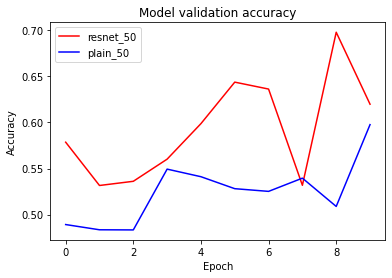

In [47]:
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()

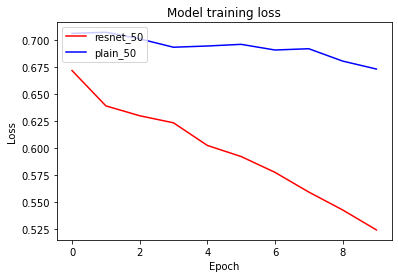

In [48]:
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()

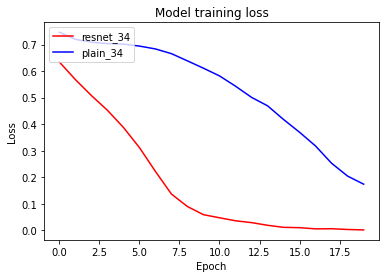

In [49]:
plt.plot(history_resnet_32.history['loss'], 'r')
plt.plot(history_plain_32.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')
plt.show()
history_resnet_32
history_plain_32

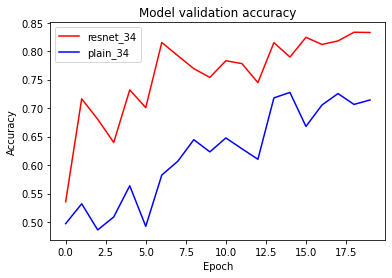

In [50]:
plt.plot(history_resnet_32.history['val_accuracy'], 'r')
plt.plot(history_plain_32.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')
plt.show()

## 회고
- 처음으로 논문 구현을 해봤는데 정말 밤을 새워가면서 구현을 했습니다..비블록화를 먼저 구현하고 어떻게 블록화를 할 수 있을지 고민을
많이 한게 코딩 실력에 많은 도움이 되었던 것 같습니다. 블록화를 함으로써 좀 더 효율적으로 코드를 짜는것을 공부했던 것 같습니다.
- 확실히 Residual(shortcut)이 Plain에 비해 성능향상에 많은 도움이 되었던 것 같습니다. 이 논문이 왜 다른논문에 Backbon이나 인용이 많이 되었는지 알게 되었던 논문인 것 같습니다.